In [1]:
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import seaborn as sns

sns.set_style('white')

%matplotlib inline

In [2]:
from matplotlib import rc,rcParams


params = {
    'text.usetex': True,
    'text.latex.preamble' : [
        r'\usepackage{siunitx}', r'\usepackage{amsmath}',
        # r'\usepackage[T1]{fontenc}', r'\usepackage[utf8]{inputenc}',
        r'\usepackage{lmodern}', r'\usepackage{fourier}'

        # r'\usepackage{siunitx}', r'\usepackage{amsmath}', r'\usepackage{sansmath}', '\sansmath'
    ],
    'font.family' : 'lmodern',
    'text.latex.unicode': False,
}

    
plt.rcParams.update(params)




In [3]:
# in-situ measurements
path_level = '..\data\water-level-ProsserCreekReservoir.csv'
data_water_level = pd.DataFrame.from_csv(path_level)

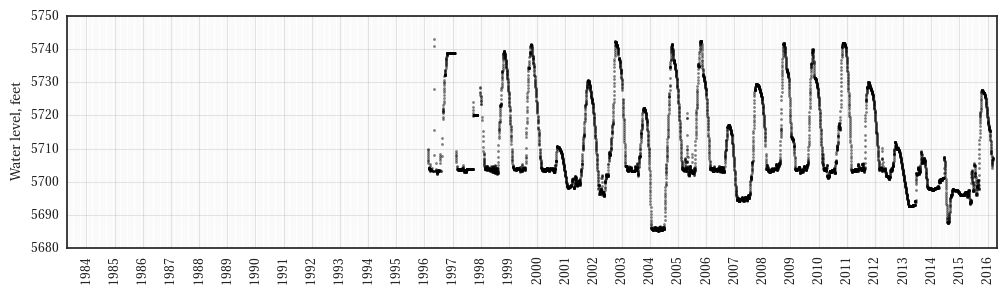

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 3))

ax1.plot(data_water_level.index, data_water_level.water_level, 'k.', markersize=4, alpha=0.5)

ax1.xaxis.set_major_locator(plt.MultipleLocator(365*1))
ax1.xaxis.set_minor_locator(plt.MultipleLocator(365/12))
ax1.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax1.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

# ax1.yaxis.set_major_locator(plt.MultipleLocator(365*1))
# ax1.yaxis.set_minor_locator(plt.MultipleLocator(365/12))
ax1.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax1.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax1.yaxis.set_label_text('Water level, feet')

ax1.set_xlim(datetime(1984, 1, 1), datetime(2017, 1, 1))

_ = plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

# data_water_level.plot(figsize=(12,3), kind='density', rot=90, lw=1)

In [138]:
pdf = PdfPages(r'..\figures\water_level_measured.pdf')
pdf.savefig(figure=fig, bbox_inches='tight', dpi=600)
pdf.close()

In [5]:
# area, cloud and snow-free only
path_area_cloudfree = '../data/area_cloud_free_only.csv'
data_area_cloudfree = pd.DataFrame.from_csv(path_area_cloudfree)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


[  5.32999676e+05  -1.90639852e+02   1.70439920e-02]
[  1.36505312e+05   4.77564302e+01   4.17688129e-03]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     2723.
Date:                Sun, 03 Sep 2017   Prob (F-statistic):          1.04e-179
Time:                        00:54:49   Log-Likelihood:                -1095.1
No. Observations:                 273   AIC:                             2196.
Df Residuals:                     270   BIC:                             2207.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------

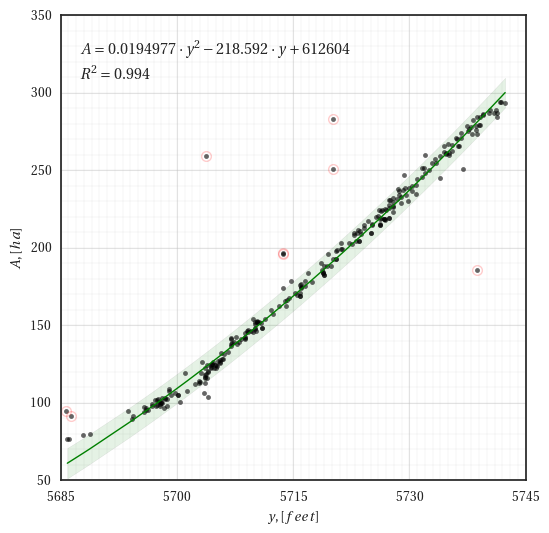

In [6]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

scatter_data = data_area_cloudfree.join(data_water_level, how='inner')
scatter_data = scatter_data.sort(['water_level'])

x = scatter_data.water_level.tolist()
X = np.column_stack((x, np.power(x, 2)))
X = sm.add_constant(X)

y = scatter_data.area.tolist()

model = sm.OLS(y, X)
results = model.fit()

print(results.params)
print(results.bse)
print(results.summary(yname='y', xname=['var_%d' % i for i in range(len(results.params))]))

test = results.outlier_test()
outliers=list(i for i,t in enumerate(test) if t[1] < 0.05)

not_outliers = np.ones(len(x), np.bool)
not_outliers[outliers] = 0

# compute stats without outliers
x = np.array(x)
y = np.array(y)

x_outliers = x[outliers]
y_outliers = y[outliers]

x = x[not_outliers]
y = y[not_outliers]

X = np.column_stack((x, np.power(x, 2)))
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

print(results.params)
print(results.bse)
print(results.summary(yname='y', xname=['var_%d' % i for i in range(len(results.params))]))

prstd, yc_l, yc_u = wls_prediction_std(results)

f = plt.figure(figsize=(6,6))
ax = plt.subplot()

ax.set_xlabel('$y, [feet]$')
ax.set_ylabel('$A, [ha]$')

ax.xaxis.set_major_locator(plt.MultipleLocator(15))
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.yaxis.set_major_locator(plt.MultipleLocator(50))
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)


ax.plot(scatter_data.water_level.tolist(), scatter_data.area.tolist(), 'k.', alpha=0.6)

ax.plot(x_outliers, y_outliers, 'ro', alpha=0.2, lw=1, markerfacecolor='None', markeredgewidth=1, markeredgecolor='r')

# add fit
ax.plot(x, results.fittedvalues, 'g-', linewidth=1)

# add 95% confidence interval
ax.fill_between(x, yc_l, yc_u, facecolor='g', alpha=0.1)

# add text

ax.text(5687.5, 325, '$A = {0:g} \cdot y^2 {1:+g} \cdot y {2:+g}$'
        .format(results.params[2], results.params[1], results.params[0]), size=12)
ax.text(5687.5, 310, '$R^2 = %.3f$' % results.rsquared, size=12)


In [17]:
import statsmodels.tools.eval_measures as m
m.rmse(y, results.fittedvalues)

4.7465914621440346

In [140]:
results.params

array([  6.12603852e+05,  -2.18592293e+02,   1.94977319e-02])

In [7]:
pdf = PdfPages(r'..\figures\water_level_and_area_scatter_cloudfree.pdf')
pdf.savefig(figure=f, bbox_inches='tight', dpi=600)
pdf.close()

## JRC data

### Export cloud-free, with outliers

In [9]:
# all scenes
path_all = '../data/multisensor-3-cloudfree-1984-01-01_2018-01-01_info_2017-04-14_12_39-all.csv'
data_all = pd.DataFrame.from_csv(path_all)

pd.options.mode.chained_assignment = None
ts_all = data_all[['system:time_start', 'water_area', 'system:id']]
ts_all['time'] = pd.to_datetime(ts_all['system:time_start'], unit='ms')
ts_all['water_area'] = ts_all['water_area'] * 0.0001




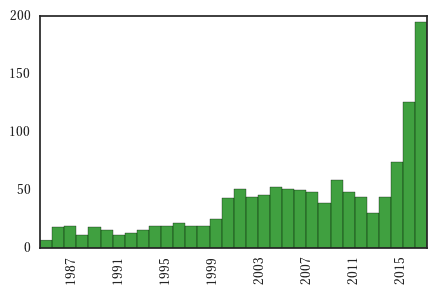

In [93]:
fig, ax1 = plt.subplots(figsize=(5, 3))

_ = plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

n, bins, patches = plt.hist(list(ts_all.time.values), 2016-1984, facecolor='green', alpha=0.75)

# ts_all.time.hist(bins=32)

In [102]:
list(n)+[1.0]

[7.0,
 18.0,
 19.0,
 11.0,
 18.0,
 16.0,
 11.0,
 13.0,
 16.0,
 19.0,
 19.0,
 22.0,
 19.0,
 19.0,
 25.0,
 43.0,
 51.0,
 44.0,
 46.0,
 53.0,
 51.0,
 50.0,
 48.0,
 39.0,
 59.0,
 48.0,
 44.0,
 30.0,
 44.0,
 74.0,
 126.0,
 195.0,
 1.0]

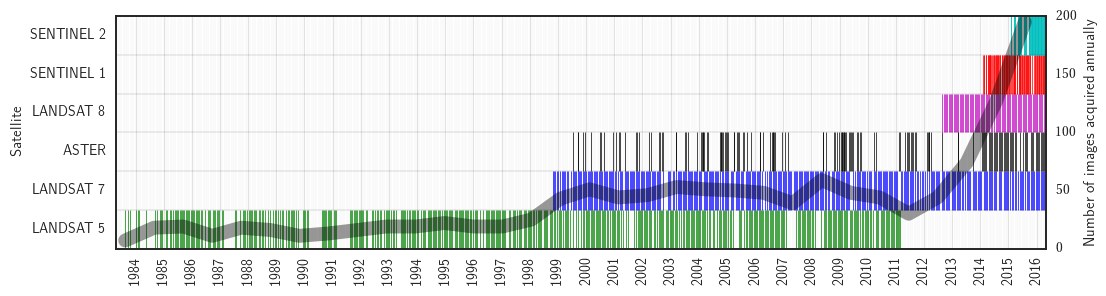

In [150]:
fig, ax1 = plt.subplots(figsize=(12, 3))

# plt.plot(list(data_all['system:time_start'].values), list(data_all.water_area.values))

# sns.rugplot(list(ts_all[ts_all['system:id'].str.contains('LT5', na=False)].time.values), color='g', lw=1)
# sns.rugplot(list(ts_all[ts_all['system:id'].str.contains('ASTER', na=False)].time.values), color='k', lw=1)
# sns.rugplot(list(ts_all[ts_all['system:id'].str.contains('LE7', na=False)].time.values), color='b', lw=1)
# sns.rugplot(list(ts_all[ts_all['system:id'].str.contains('LC8', na=False)].time.values), color='m', lw=1)
# sns.rugplot(list(ts_all[ts_all['system:id'].str.contains('S1', na=False)].time.values), color='r', lw=1)
# sns.rugplot(list(ts_all[ts_all['system:id'].str.contains('S2', na=False)].time.values), color='c', lw=1)

lw = 0.5
ax1.vlines(list(ts_all[ts_all['system:id'].str.contains('LT5', na=False)].time.values), ymin=0.0, ymax=0.1, color='g', lw=lw)
ax1.vlines(list(ts_all[ts_all['system:id'].str.contains('LE7', na=False)].time.values), ymin=0.1, ymax=0.2, color='b', lw=lw)
ax1.vlines(list(ts_all[ts_all['system:id'].str.contains('ASTER', na=False)].time.values), ymin=0.2, ymax=0.3, color='k', lw=lw)
ax1.vlines(list(ts_all[ts_all['system:id'].str.contains('LC8', na=False)].time.values), ymin=0.3, ymax=0.4, color='m', lw=lw)
ax1.vlines(list(ts_all[ts_all['system:id'].str.contains('S1', na=False)].time.values), ymin=0.4, ymax=0.5, color='r', lw=lw)
ax1.vlines(list(ts_all[ts_all['system:id'].str.contains('S2', na=False)].time.values), ymin=0.5, ymax=0.6, color='c', lw=lw)

# ticks_y = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
# plt.grid(b=True, which='major', color='k', linestyle='-', alpha=0.2)
plt.hlines([0.1, 0.2, 0.3, 0.4, 0.5], xmin=0, xmax=ts_all.time.max(), lw=0.2, alpha=0.5)

labels_y = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55]
labels = ['LANDSAT 5', 'LANDSAT 7', 'ASTER', 'LANDSAT 8', 'SENTINEL 1', 'SENTINEL 2']
plt.yticks(labels_y, labels)
ax1.set_yticks(labels_y, minor=False)

ax1.yaxis.set_label_text('Satellite')

ax2 = ax1.twinx()
ax2.plot(bins[:-1], n, lw=10, alpha=0.4, color='k')
ax2.yaxis.set_label_text('Number of images acquired annually')

ax1.xaxis.set_major_locator(plt.MultipleLocator(365*1))
ax1.xaxis.set_minor_locator(plt.MultipleLocator(365/12))
ax1.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax1.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax1.set_xlim(datetime(1984, 1, 1), datetime(2017, 1, 1))

_ = plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

In [149]:
print(len(ts_all))

1297


In [153]:
pdf = PdfPages(r'..\figures\rug.pdf')
pdf.savefig(figure=fig, bbox_inches='tight', dpi=600)
pdf.close()

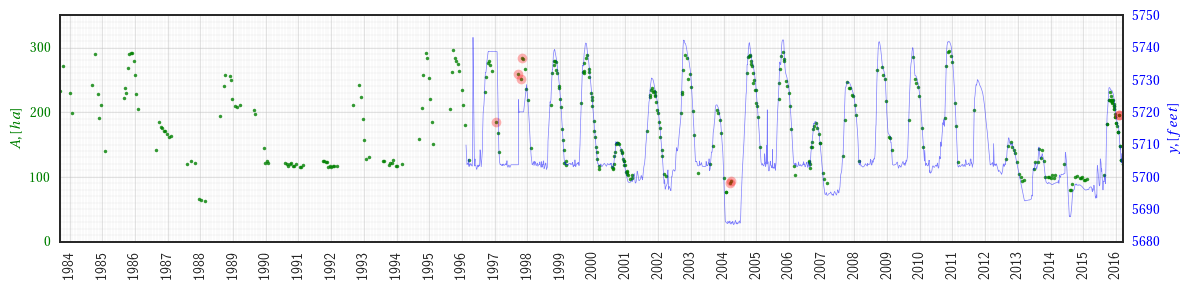

In [154]:
fig, ax1 = plt.subplots(figsize=(12, 3))

plt.plot(list(data_area_cloudfree.index), list(data_area_cloudfree.area), 'g.', markersize=5, alpha=0.8)
ax1.set_ylabel('$A, [ha]$', color='g')
ax1.tick_params('y', colors='g')
plt.ylim(0, 350)

ax1.plot(scatter_data.index[outliers], scatter_data.area[outliers], 'ro', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(list(data_water_level.index), list(data_water_level.water_level), 'b-', alpha=0.5, lw=0.5)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('$y, [feet]$', color='b')
ax2.tick_params('y', colors='b')

# data_area_cloudfree.join(data_water_level, how='inner').water_level.plot(ax=ax2, lw=0.2, c='r', style='.', alpha=0.5)
# ax2.set_xlim(datetime(2010, 1, 1), datetime(2016, 1, 1))

ax1.xaxis.set_major_locator(plt.MultipleLocator(365*1))
ax1.xaxis.set_minor_locator(plt.MultipleLocator(365/12))
ax1.yaxis.set_major_locator(plt.MultipleLocator(100.0))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(10.0))
ax1.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax1.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)
ax1.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax1.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

_ = plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

fig.tight_layout()
plt.show()


In [142]:
pdf = PdfPages(r'..\figures\water_level_and_area_timeseries_cloudfree.pdf')
pdf.savefig(figure=fig, bbox_inches='tight', dpi=600)
pdf.close()

In [155]:
# data_area_cloudfree.resample('D').merge(data_water_level.resample('D'), on='time')
data_area_cloudfree.join(data_water_level, how='inner')

,area,water_level
time,,
1996-11-20,126.582221,5703.21
1997-05-15,231.163038,5728.38
1997-05-31,254.861005,5732.93
1997-06-16,275.359786,5737.60
1997-07-18,273.555115,5738.72
1997-09-20,185.353107,5738.72
1997-10-22,138.522357,5707.14
1998-05-18,258.907916,5703.75
1998-06-19,250.577135,5720.10


(733773.0, 735964.0)

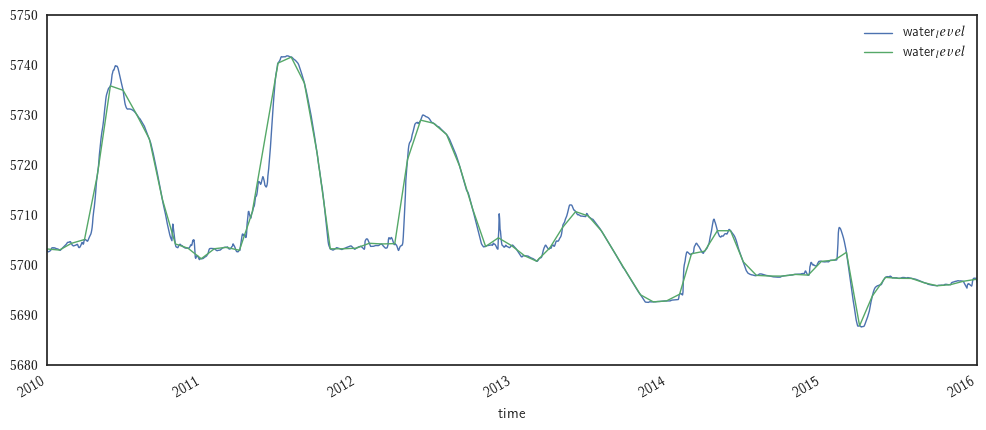

In [157]:
f = plt.figure(figsize=(12, 5))
ax = plt.subplot()
data_water_level.plot(ax=ax, lw=1)
data_water_level.resample('M').interpolate(method='time').plot(ax=ax, lw=1)
ax.set_xlim(datetime(2010, 1, 1), datetime(2016, 1, 1))

In [159]:
# time series estimated using different methods

path = '..\data\multisensor-3-cloudfree-1984-01-01_2017-04-01_info_30m.csv'
# path = '..\data\multisensor-3-cloudfree-1984-01-01_2017-04-01_info_fill_30m.csv'
# path = '..\data\multisensor-3-cloudfree-1984-01-01_2017-04-01_info_NDWI0_30m.csv'


In [160]:
data=pd.DataFrame.from_csv(path)

In [161]:
data[data.SENSOR_ID.isnull()]['SENSOR_ID'] =  data

In [19]:
print(list(data.columns))

['CLOUD_COVER', 'CORNER_LL_LAT_PRODUCT', 'CORNER_LL_LON_PRODUCT', 'CORNER_LL_PROJECTION_X_PRODUCT', 'CORNER_LL_PROJECTION_Y_PRODUCT', 'CORNER_LR_LAT_PRODUCT', 'CORNER_LR_LON_PRODUCT', 'CORNER_LR_PROJECTION_X_PRODUCT', 'CORNER_LR_PROJECTION_Y_PRODUCT', 'CORNER_UL_LAT_PRODUCT', 'CORNER_UL_LON_PRODUCT', 'CORNER_UL_PROJECTION_X_PRODUCT', 'CORNER_UL_PROJECTION_Y_PRODUCT', 'CORNER_UR_LAT_PRODUCT', 'CORNER_UR_LON_PRODUCT', 'CORNER_UR_PROJECTION_X_PRODUCT', 'CORNER_UR_PROJECTION_Y_PRODUCT', 'CORRECTION_BIAS_BAND_1', 'CORRECTION_GAIN_BAND_1', 'CORRECTION_GAIN_BAND_2', 'CORRECTION_GAIN_BAND_3', 'CORRECTION_GAIN_BAND_4', 'CORRECTION_GAIN_BAND_5', 'CORRECTION_GAIN_BAND_6', 'CORRECTION_GAIN_BAND_7', 'CPF_NAME', 'DATA_TYPE', 'DATE_ACQUIRED', 'DATUM', 'ELEVATION_SOURCE', 'ELLIPSOID', 'EPHEMERIS_TYPE', 'FILE_DATE', 'FILE_NAME_BAND_1', 'FILE_NAME_BAND_2', 'FILE_NAME_BAND_3', 'FILE_NAME_BAND_4', 'FILE_NAME_BAND_5', 'FILE_NAME_BAND_6', 'FILE_NAME_BAND_7', 'GRID_CELL_SIZE_REFLECTIVE', 'GRID_CELL_SIZE_THER

In [162]:
pd.options.mode.chained_assignment = None
ts = data[['system:time_start', 'water_area', 'SENSOR_ID']]
ts['time'] = pd.to_datetime(ts['system:time_start'], unit='ms')
ts['water_area'] = ts['water_area'] * 0.0001
ts

,system:time_start,water_area,SENSOR_ID,time
system:index,,,,
1_1_1_2_LT50430331984116PAC00,4.517644e+11,162.156502,TM,1984-04-25 18:06:39.300
1_1_1_2_LT50430331984148PAC00,4.545292e+11,233.150032,TM,1984-05-27 18:07:26.818
1_1_1_2_LT50430331984180XXX16,4.572941e+11,272.042048,TM,1984-06-28 18:07:58.909
1_1_1_2_LT50430331984260PAC00,4.642062e+11,229.385709,TM,1984-09-16 18:09:36.564
1_1_1_2_LT50430331984276XXX03,4.655886e+11,199.544519,TM,1984-10-02 18:09:36.776
1_1_1_2_LT50430331984292XXX02,4.669710e+11,141.885772,TM,1984-10-18 18:09:33.908
1_1_1_2_LT50430331985022XXX04,4.752654e+11,0.000000,TM,1985-01-22 18:09:52.568
1_1_1_2_LT50430331985134PAC04,4.849422e+11,241.571929,TM,1985-05-14 18:09:36.622
1_1_1_2_LT50430331985166PAC05,4.877070e+11,289.469185,TM,1985-06-15 18:09:35.558


In [171]:

ts.water_area

system:index
1_1_1_2_LT50430331984116PAC00                                                              162.156502
1_1_1_2_LT50430331984148PAC00                                                              233.150032
1_1_1_2_LT50430331984180XXX16                                                              272.042048
1_1_1_2_LT50430331984260PAC00                                                              229.385709
1_1_1_2_LT50430331984276XXX03                                                              199.544519
1_1_1_2_LT50430331984292XXX02                                                              141.885772
1_1_1_2_LT50430331985022XXX04                                                                0.000000
1_1_1_2_LT50430331985134PAC04                                                              241.571929
1_1_1_2_LT50430331985166PAC05                                                              289.469185
1_1_1_2_LT50430331985198PAC05                                        

In [163]:
import seaborn as sns

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


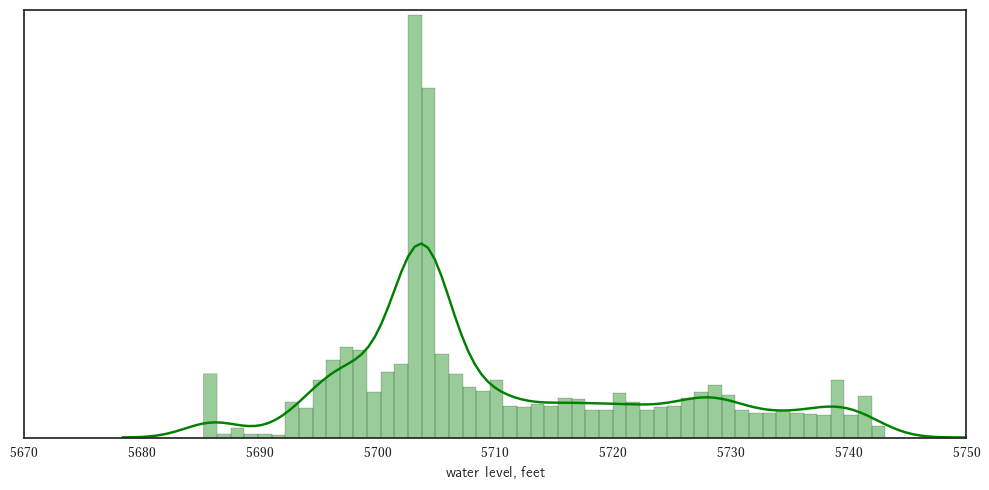

In [164]:
d = data_water_level.water_level

f = plt.figure(figsize=(10,5))

sns.set_style('white')
sns.distplot(d, hist=True, color="g", kde_kws={"shade": False}, bins=50)

f.axes[0].get_yaxis().set_ticks([])
plt.tight_layout()
plt.xlabel('water level, feet')

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(0, 500)

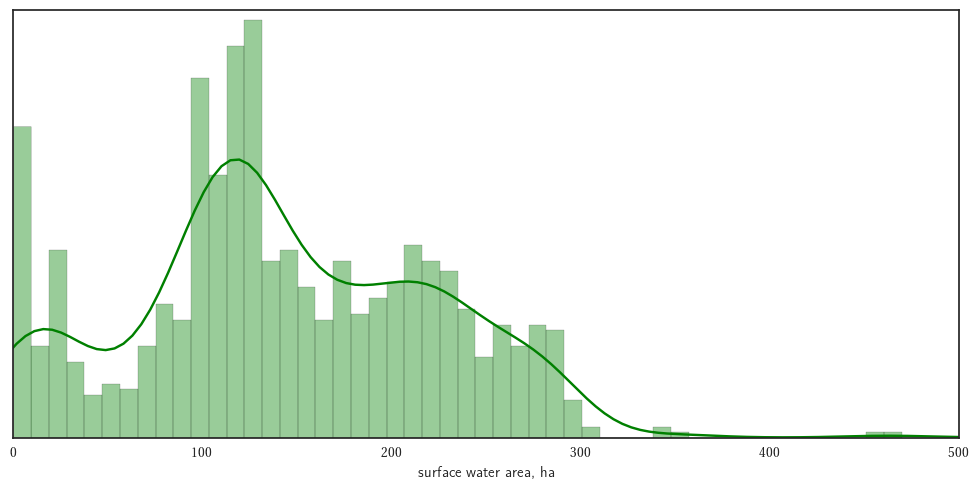

In [165]:
d = ts[ts['water_area']>0]['water_area']


f = plt.figure(figsize=(10,5))

sns.set_style('white')
sns.distplot(d, hist=True, color="g", kde_kws={"shade": False}, bins=50)

f.axes[0].get_yaxis().set_ticks([])
plt.tight_layout()
plt.xlabel('surface water area, ha')
plt.xlim(0, 500)

In [166]:
import numpy as np
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

ts = ts[ts['water_area']>0] 

d=pd.DataFrame(list(ts['water_area']), index=list(pd.to_datetime(ts['system:time_start'], unit='ms')), columns=['A'])

d

,A
1984-04-25 18:06:39.300,162.156502
1984-05-27 18:07:26.818,233.150032
1984-06-28 18:07:58.909,272.042048
1984-09-16 18:09:36.564,229.385709
1984-10-02 18:09:36.776,199.544519
1984-10-18 18:09:33.908,141.885772
1985-05-14 18:09:36.622,241.571929
1985-06-15 18:09:35.558,289.469185
1985-07-17 18:09:24.887,229.112219
1985-08-02 18:09:17.065,190.995052


## Compare to in-situ observations

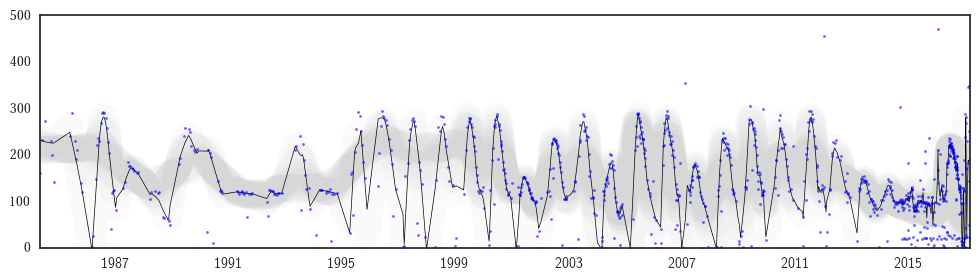

In [167]:
f = plt.figure(figsize=(12,3))

xx = d.index
yy = d.A


for frac in np.arange(0.01, 0.05, 0.005):
    lowess = sm.nonparametric.lowess(yy, xx, frac=frac)
    plt.plot(list(xx), lowess[:, 1], c='black', lw=20, alpha=0.02)
    
lowess = sm.nonparametric.lowess(yy, xx, frac=0.01, it=102)

# plt.plot(lowess[:, 0], lowess[:, 1], c='black', lw=1)    
plt.plot(list(xx), lowess[:, 1], c='black', lw=0.5)    

plt.plot(list(xx), list(yy), '.', color='blue', markersize=4, alpha=0.6)

#_ = plt.xlim(1e12, 1.5e12)
_ = plt.ylim(0, 500)

In [168]:
pdf = PdfPages(r'..\figures\lowes_fit.pdf')
pdf.savefig(figure=f, bbox_inches='tight')
pdf.close()

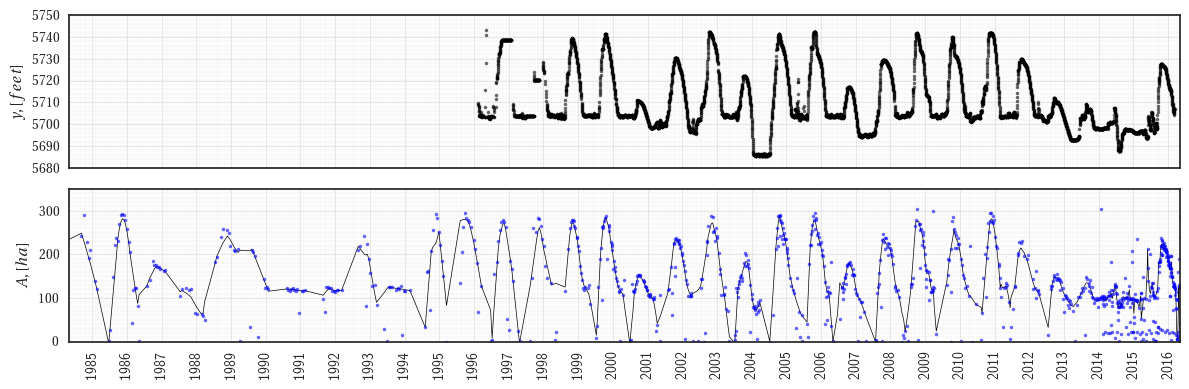

In [216]:
f = plt.figure(figsize=(12,4))

plt1 = plt.subplot(2, 1, 1)
plt1.plot(list(data_water_level.index), list(data_water_level.water_level), '.', markersize=5, alpha=0.6, color='black')
plt1.xaxis.set_major_locator(plt.MultipleLocator(365.0))
plt1.xaxis.set_minor_locator(plt.MultipleLocator(365/12))
plt1.yaxis.set_major_locator(plt.MultipleLocator(10.0))
plt1.yaxis.set_minor_locator(plt.MultipleLocator(2.0))
plt1.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt1.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)
plt1.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt1.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)
plt1.set_xticklabels([])
plt1.set_ylabel(r'$y, [feet]$', fontsize=12)
plt.xlim(datetime(1985, 1, 1), datetime(2017, 1, 1))

# plt.plot(lowess[:, 0], lowess[:, 1], c='black', lw=1)    
plt2 = plt.subplot(2, 1, 2)
lowess = sm.nonparametric.lowess(yy, xx, frac=0.01, it=102)
plt2.plot(xx, lowess[:, 1], c='black', lw=0.5)    
plt2.plot(xx, yy, '.', color='blue', markersize=5, alpha=0.6)
plt2.xaxis.set_major_locator(plt.MultipleLocator(365.0))
plt2.xaxis.set_minor_locator(plt.MultipleLocator(365/12))
plt2.yaxis.set_major_locator(plt.MultipleLocator(100.0))
plt2.yaxis.set_minor_locator(plt.MultipleLocator(10.0))
plt2.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt2.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)
plt2.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt2.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)

plt.ylim(0, 350)
plt.xlim(datetime(1985, 1, 1), datetime(2017, 1, 1))

_ = plt.setp(plt2.xaxis.get_majorticklabels(), rotation=90)

plt2.set_ylabel(r'$A, [ha]$', fontsize=12)

f.tight_layout()


In [217]:
pdf = PdfPages(r'..\figures\water_level_and_area_lowess_all.pdf')
pdf.savefig(figure=f, bbox_inches='tight')
pdf.close()

In [174]:
xx


1984-04-25 18:06:39.300    162.156502
1984-05-27 18:07:26.818    233.150032
1984-06-28 18:07:58.909    272.042048
1984-09-16 18:09:36.564    229.385709
1984-10-02 18:09:36.776    199.544519
1984-10-18 18:09:33.908    141.885772
1985-05-14 18:09:36.622    241.571929
1985-06-15 18:09:35.558    289.469185
1985-07-17 18:09:24.887    229.112219
1985-08-02 18:09:17.065    190.995052
1985-08-18 18:09:07.340    211.074395
1985-10-05 18:08:34.067    139.588781
1985-10-21 18:08:23.009    119.555039
1986-02-26 18:05:55.133      1.057284
1986-03-14 18:05:35.470     26.815027
1986-04-15 18:04:55.253    147.491077
1986-05-01 18:04:32.065    221.392172
1986-05-17 18:04:06.371    237.196919
1986-06-02 18:03:38.382    230.780212
1986-06-18 18:03:08.473    269.015991
1986-07-04 18:02:37.127    289.378049
1986-07-20 18:02:04.310    292.258262
1986-08-05 18:01:30.023    291.273880
1986-08-21 18:00:54.314    279.616303
1986-09-06 18:00:18.484    257.950860
1986-09-22 17:59:49.395    227.827091
1986-10-08 1

In [194]:
d['date'] = d.index
d['date'] = d['date'].apply(lambda x: x.date())
d.index = d['date']

In [201]:
scatter_data_all = d.join(data_water_level, how='inner')
#scatter_data_all = scatter_data_all.sort(['water_level'])


In [202]:
scatter_data_all

,A,date,water_level
1996-10-19,68.385805,1996-10-19,5709.44
1996-11-20,126.773626,1996-11-20,5703.21
1997-02-24,2.351569,1997-02-24,5703.39
1997-03-28,154.327101,1997-03-28,5707.26
1997-04-29,181.853462,1997-04-29,5720.74
1997-05-15,231.163036,1997-05-15,5728.38
1997-05-31,254.943034,1997-05-31,5732.93
1997-06-16,275.359795,1997-06-16,5737.60
1997-07-18,273.555114,1997-07-18,5738.72
1997-09-04,26.969756,1997-09-04,5738.72


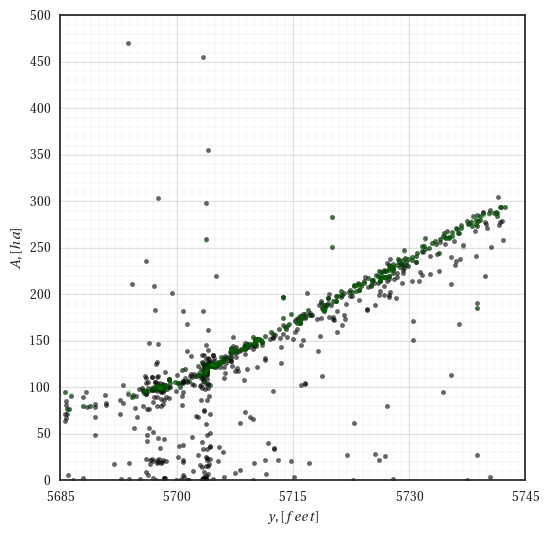

In [208]:
f = plt.figure(figsize=(6,6))
ax = plt.subplot()

ax.set_xlabel('$y, [feet]$')
ax.set_ylabel('$A, [ha]$')

ax.xaxis.set_major_locator(plt.MultipleLocator(15))
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.yaxis.set_major_locator(plt.MultipleLocator(50))
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.plot(scatter_data_all.water_level.tolist(), scatter_data_all.A.tolist(), 'k.', alpha=0.6)
ax.plot(scatter_data.water_level.tolist(), scatter_data.area.tolist(), 'g.', alpha=0.3)



In [ ]:
f = plt.figure(figsize=(6,6))
ax = plt.subplot()

ax.set_xlabel('$y, [feet]$')
ax.set_ylabel('$A, [ha]$')

ax.xaxis.set_major_locator(plt.MultipleLocator(15))
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.yaxis.set_major_locator(plt.MultipleLocator(50))
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.plot(scatter_data.water_level.tolist(), scatter_data.area.tolist(), 'k.', alpha=0.6)


f = plt.figure(figsize=(12,4))

plt1 = plt.subplot(2, 1, 1)
plt1.plot(list(data_water_level.index), list(data_water_level.water_level), '.', markersize=5, alpha=0.6, color='black')
plt1.xaxis.set_major_locator(plt.MultipleLocator(365.0))
plt1.xaxis.set_minor_locator(plt.MultipleLocator(365/12))
plt1.yaxis.set_major_locator(plt.MultipleLocator(10.0))
plt1.yaxis.set_minor_locator(plt.MultipleLocator(2.0))
plt1.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt1.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)
plt1.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt1.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)
plt1.set_xticklabels([])
plt1.set_ylabel(r'$y, [feet]$', fontsize=12)
plt.xlim(datetime(1985, 1, 1), datetime(2017, 1, 1))

# plt.plot(lowess[:, 0], lowess[:, 1], c='black', lw=1)    
plt2 = plt.subplot(2, 1, 2)
lowess = sm.nonparametric.lowess(yy, xx, frac=0.01, it=102)
plt2.plot(xx, lowess[:, 1], c='black', lw=0.5)    
plt2.plot(xx, yy, '.', color='blue', markersize=5, alpha=0.6)
plt2.xaxis.set_major_locator(plt.MultipleLocator(365.0))
plt2.xaxis.set_minor_locator(plt.MultipleLocator(365/12))
plt2.yaxis.set_major_locator(plt.MultipleLocator(100.0))
plt2.yaxis.set_minor_locator(plt.MultipleLocator(10.0))
plt2.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt2.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)
plt2.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt2.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)

plt.ylim(0, 350)
plt.xlim(datetime(1985, 1, 1), datetime(2017, 1, 1))


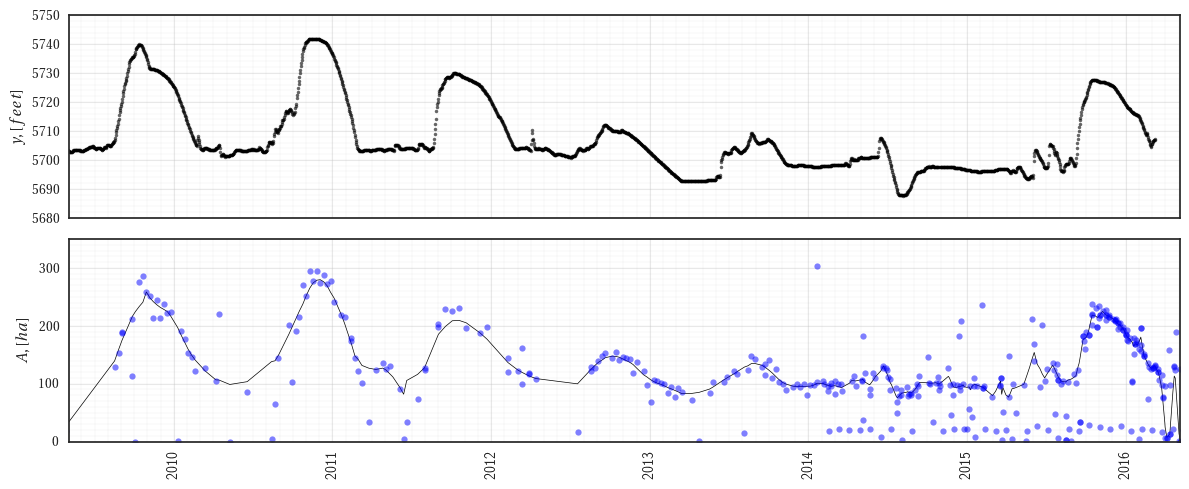

In [214]:
f = plt.figure(figsize=(12,5))

plt1 = plt.subplot(2, 1, 1)
plt1.plot(list(data_water_level.index), list(data_water_level.water_level), '.', markersize=5, alpha=0.6, color='black')
plt1.xaxis.set_major_locator(plt.MultipleLocator(365.0))
plt1.xaxis.set_minor_locator(plt.MultipleLocator(365/12))
plt1.yaxis.set_major_locator(plt.MultipleLocator(10.0))
plt1.yaxis.set_minor_locator(plt.MultipleLocator(2.0))
plt1.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt1.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)
plt1.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt1.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)
plt1.set_xticklabels([])
plt1.set_ylabel(r'$y, [feet]$', fontsize=12)
plt.xlim(datetime(2010, 1, 1), datetime(2017, 1, 1))

# plt.plot(lowess[:, 0], lowess[:, 1], c='black', lw=1)    
plt2 = plt.subplot(2, 1, 2)
lowess = sm.nonparametric.lowess(yy, xx, frac=0.011, it=50)
plt2.plot(xx, lowess[:, 1], c='black', lw=0.5)    
plt2.plot(xx, yy, '.', color='blue', markersize=9, alpha=0.5)
plt2.xaxis.set_major_locator(plt.MultipleLocator(365.0))
plt2.xaxis.set_minor_locator(plt.MultipleLocator(365/12))
plt2.yaxis.set_major_locator(plt.MultipleLocator(100.0))
plt2.yaxis.set_minor_locator(plt.MultipleLocator(10.0))
plt2.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt2.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)
plt2.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt2.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)

plt.ylim(0, 350)
plt.xlim(datetime(2010, 1, 1), datetime(2017, 1, 1))

plt2.set_ylabel(r'$A, [ha]$', fontsize=12)

_ = plt.setp(plt2.xaxis.get_majorticklabels(), rotation=90)

f.tight_layout()


In [215]:
pdf = PdfPages(r'..\figures\water_level_and_area_timeseries_lowess_all_zoom.pdf')
pdf.savefig(figure=f, bbox_inches='tight', dpi=600)
pdf.close()

In [263]:
path = '..\data\multisensor-3-cloudfree-1984-01-01_2017-04-01_info_fill_30m.csv'
data_all=pd.DataFrame.from_csv(path)
data_all['time'] = pd.to_datetime(data_all['system:time_start'], unit='ms')
data_all['water_area'] = data_all['water_area'] * 0.0001
data_all = pd.DataFrame(data_all.water_area.tolist(), index=data_all.time.tolist(), columns=['water_area'])
data_all['date'] = data_all.index.date
data_all = pd.DataFrame(data_all.water_area.tolist(), index=data_all.date.tolist(), columns=['water_area'])
scatter_data_all = data_all.join(data_water_level, how='inner')
scatter_data_all = scatter_data_all.sort(['water_level'])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(-1, 550)

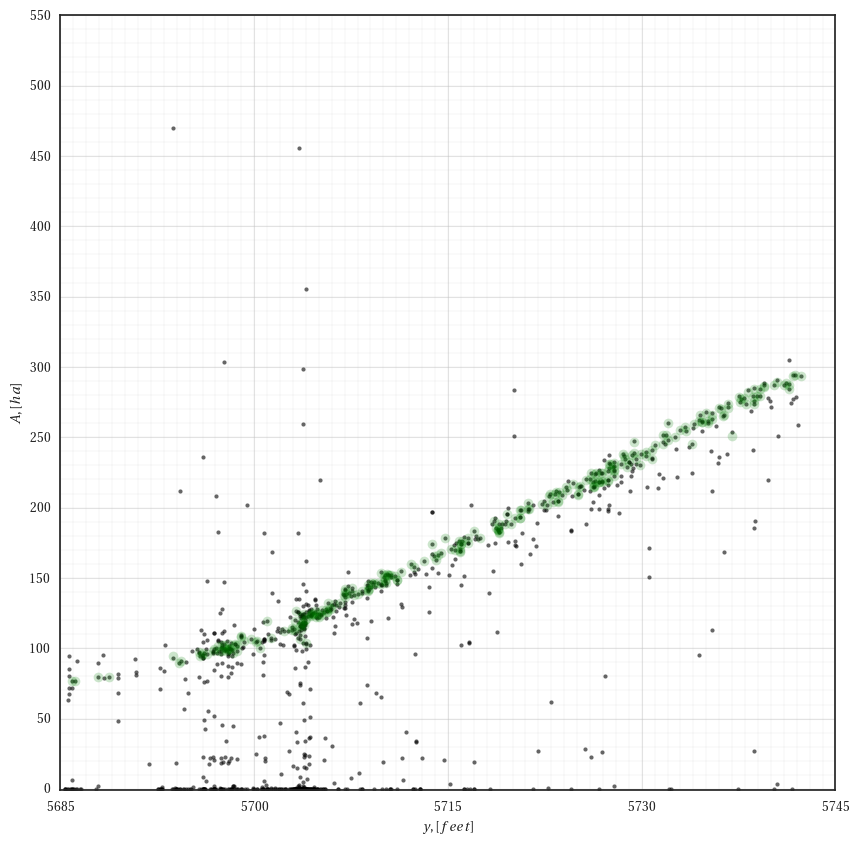

In [265]:
f = plt.figure(figsize=(10,10))
ax = plt.subplot()

ax.set_xlabel('$y, [feet]$')
ax.set_ylabel('$A, [ha]$')

ax.xaxis.set_major_locator(plt.MultipleLocator(15))
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.yaxis.set_major_locator(plt.MultipleLocator(50))
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.plot(scatter_data_all.water_level.tolist(), scatter_data_all.water_area.tolist(), 'k.', alpha=0.6, markersize=6)
ax.plot(x, y, 'go', alpha=0.2)

ax.set_ylim(-1, 550)



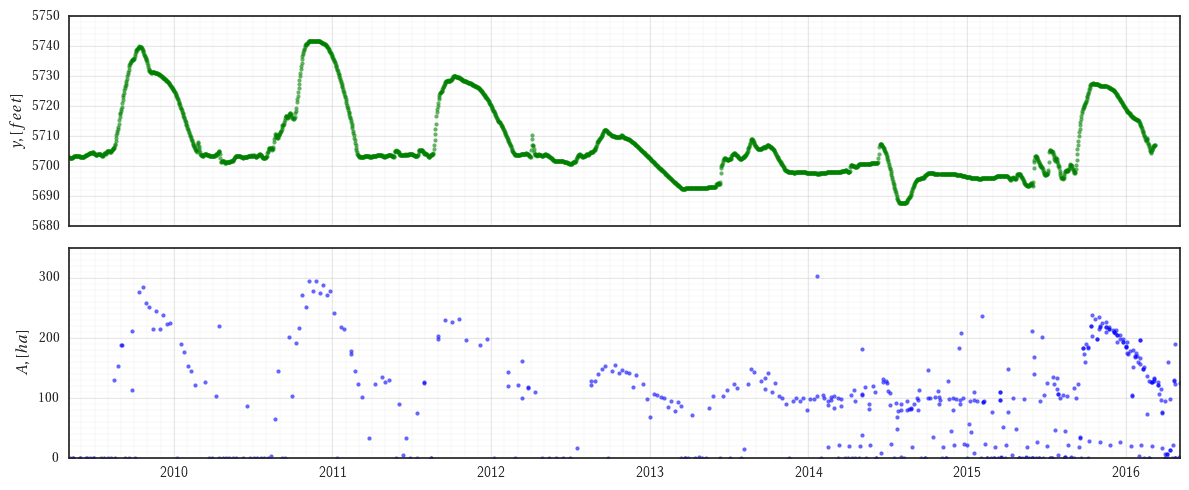

In [258]:
f = plt.figure(figsize=(12,5))

xx = list(x)
yy = list(y)

plt1 = plt.subplot(2, 1, 1)
plt1.plot(list(data_water_level.index), list(data_water_level.water_level), '.', markersize=6, alpha=0.6, color='green')
plt1.xaxis.set_major_locator(plt.MultipleLocator(365.0))
plt1.xaxis.set_minor_locator(plt.MultipleLocator(365/12))
plt1.yaxis.set_major_locator(plt.MultipleLocator(10.0))
plt1.yaxis.set_minor_locator(plt.MultipleLocator(2.0))
plt1.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt1.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)
plt1.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt1.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)
plt1.set_xticklabels([])
plt1.set_ylabel(r'$y, [feet]$', fontsize=12)
plt.xlim(datetime(2010, 1, 1), datetime(2017, 1, 1))



# plt.plot(lowess[:, 0], lowess[:, 1], c='black', lw=1)    
plt2 = plt.subplot(2, 1, 2)
#lowess = sm.nonparametric.lowess(y, x, frac=0.01, it=102)
#plt2.plot(xx, lowess[:, 1], c='black', lw=0.5)    
plt2.plot(data_all.index, data_all.water_area, '.', color='blue', markersize=6, alpha=0.6)
plt2.xaxis.set_major_locator(plt.MultipleLocator(365.0))
plt2.xaxis.set_minor_locator(plt.MultipleLocator(365/12))
plt2.yaxis.set_major_locator(plt.MultipleLocator(100.0))
plt2.yaxis.set_minor_locator(plt.MultipleLocator(10.0))
plt2.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt2.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)
plt2.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.3)
plt2.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.3)

plt.ylim(0, 350)
plt.xlim(datetime(2010, 1, 1), datetime(2017, 1, 1))

plt2.set_ylabel(r'$A, [ha]$', fontsize=12)

f.tight_layout()


In [136]:
len(data_all)

1285

In [267]:
path = '..\data\multisensor-3-cloudfree-1984-01-01_2017-04-01_info_NDWI0_30m.csv'
data_all=pd.DataFrame.from_csv(path)
data_all['time'] = pd.to_datetime(data_all['system:time_start'], unit='ms')
data_all['water_area'] = data_all['water_area'] * 0.0001
data_all = pd.DataFrame(data_all.water_area.tolist(), index=data_all.time.tolist(), columns=['water_area'])
data_all['date'] = data_all.index.date
data_all = pd.DataFrame(data_all.water_area.tolist(), index=data_all.date.tolist(), columns=['water_area'])
scatter_data_all = data_all.join(data_water_level, how='inner')
scatter_data_all = scatter_data_all.sort(['water_level'])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(-1, 550)

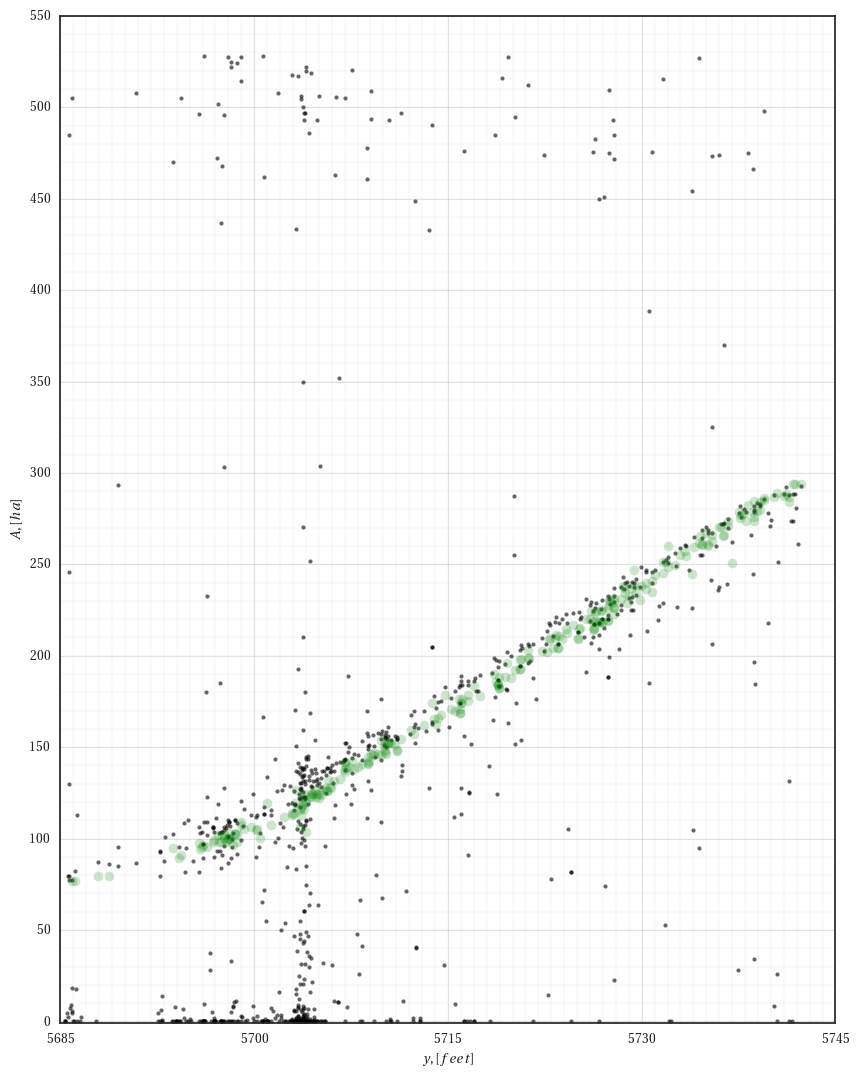

In [268]:
f = plt.figure(figsize=(10,13))
ax = plt.subplot()

ax.set_xlabel('$y, [feet]$')
ax.set_ylabel('$A, [ha]$')

ax.xaxis.set_major_locator(plt.MultipleLocator(15))
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.yaxis.set_major_locator(plt.MultipleLocator(50))
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.plot(scatter_data_all.water_level.tolist(), scatter_data_all.water_area.tolist(), 'k.', alpha=0.6, markersize=6)
ax.plot(x, y, 'go', alpha=0.2)

ax.set_ylim(-1, 550)



In [295]:
path = '..\data\multisensor-3-cloudfree-1984-01-01_2018-01-01_info_2017-04-09_20_22.csv'
path = '..\data\multisensor-3-cloudfree-1984-01-01_2018-01-01_info_2017-04-14_22_59_p01.csv'
data_all=pd.DataFrame.from_csv(path)
data_all['time'] = pd.to_datetime(data_all['system:time_start'], unit='ms')
data_all['water_area'] = data_all['water_area'] * 0.0001
data_all['expected_area'] = data_all['expected_area'] * 0.0001

print(len(data_all))
data_all['outlier1'] = data_all['snow_pixels'] > 1000
data_all['outlier2'] = data_all['expected_area_fraction'] < 0.2
data_all['outlier3'] = data_all['expected_area_fraction'] > 1.5
data_all['outlier4'] = data_all['asset'].str.contains('S1VV')


data_all = data_all[~data_all['outlier1']]
data_all = data_all[~data_all['outlier2']]
data_all = data_all[~data_all['outlier3']]
data_all = data_all[~data_all['outlier4']]

data_all = pd.DataFrame(data_all.expected_area.tolist(), index=data_all.time.tolist(), columns=['expected_area'])
data_all['date'] = data_all.index.date
data_all = pd.DataFrame(data_all.expected_area.tolist(), index=data_all.date.tolist(), columns=['expected_area'])
scatter_data_all = data_all.join(data_water_level, how='inner')
scatter_data_all = scatter_data_all.sort(['water_level'])

print(len(data_all))

1297
622


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(-1, 350)

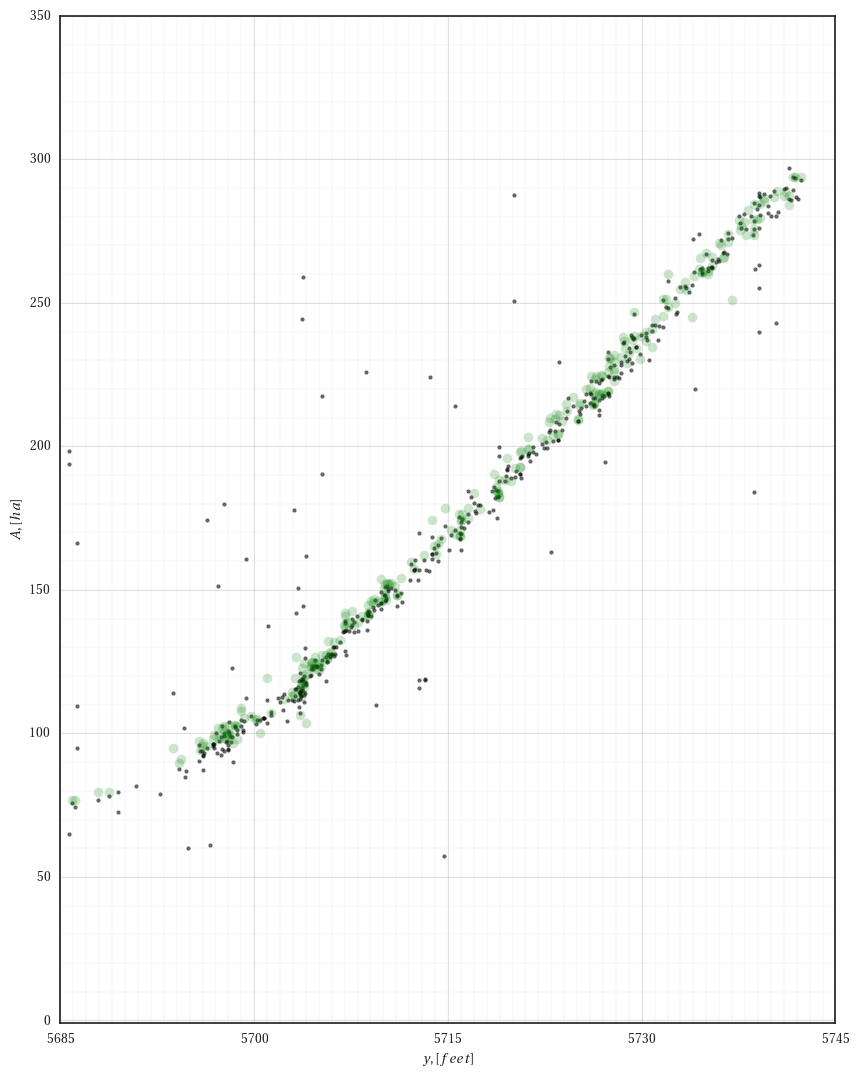

In [296]:
f = plt.figure(figsize=(10,13))
ax = plt.subplot()

ax.set_xlabel('$y, [feet]$')
ax.set_ylabel('$A, [ha]$')

ax.xaxis.set_major_locator(plt.MultipleLocator(15))
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.yaxis.set_major_locator(plt.MultipleLocator(50))
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.plot(scatter_data_all.water_level.tolist(), scatter_data_all.expected_area.tolist(), 'k.', alpha=0.6, markersize=6)
ax.plot(x, y, 'go', alpha=0.2)

ax.set_ylim(-1, 350)



In [297]:
path = '..\data\multisensor-3-cloudfree-1984-01-01_2018-01-01_info_2017-04-09_20_22.csv'
path = '..\data\multisensor-3-cloudfree-1984-01-01_2018-01-01_info_2017-04-14_22_59_p01.csv'
data_all=pd.DataFrame.from_csv(path)
data_all['time'] = pd.to_datetime(data_all['system:time_start'], unit='ms')
data_all['water_area'] = data_all['water_area'] * 0.0001

print(len(data_all))
data_all['outlier1'] = data_all['snow_pixels'] > 1000
data_all['outlier2'] = data_all['expected_area_fraction'] < 0.2
data_all['outlier3'] = data_all['expected_area_fraction'] > 1.5
data_all['outlier4'] = data_all['asset'].str.contains('S1VV')


data_all = data_all[~data_all['outlier1']]
data_all = data_all[~data_all['outlier2']]
data_all = data_all[~data_all['outlier3']]
data_all = data_all[~data_all['outlier4']]

data_all = pd.DataFrame(data_all.water_area.tolist(), index=data_all.time.tolist(), columns=['water_area'])
data_all['date'] = data_all.index.date
data_all = pd.DataFrame(data_all.water_area.tolist(), index=data_all.date.tolist(), columns=['water_area'])
scatter_data_all = data_all.join(data_water_level, how='inner')
scatter_data_all = scatter_data_all.sort(['water_level'])

print(len(data_all))

1297
622


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(-1, 350)

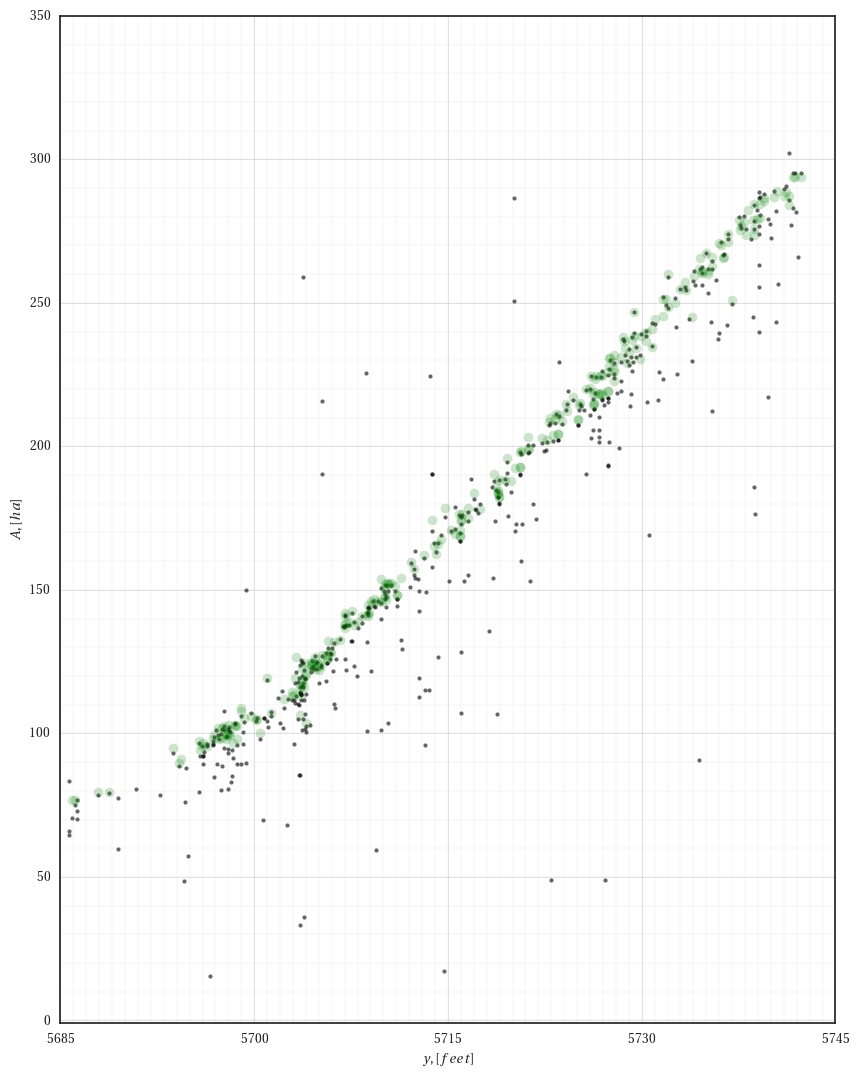

In [299]:
f = plt.figure(figsize=(10,13))
ax = plt.subplot()

ax.set_xlabel('$y, [feet]$')
ax.set_ylabel('$A, [ha]$')

ax.xaxis.set_major_locator(plt.MultipleLocator(15))
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.yaxis.set_major_locator(plt.MultipleLocator(50))
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)

ax.plot(scatter_data_all.water_level.tolist(), scatter_data_all.water_area.tolist(), 'k.', alpha=0.6, markersize=6)
ax.plot(x, y, 'go', alpha=0.2)

ax.set_ylim(-1, 350)



In [37]:
xi=ts['system:time_start']

X = xi
X = sm.add_constant(X, prepend=False)

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


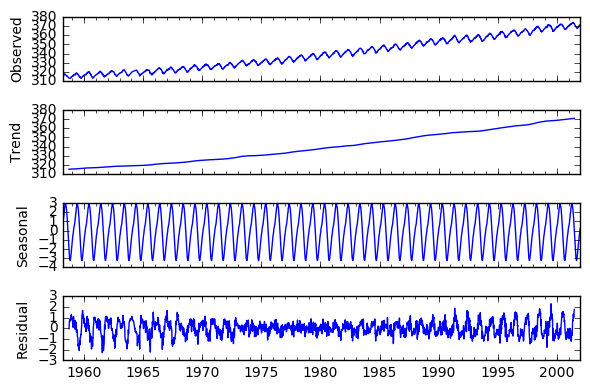

In [9]:
fig = plt.figure(figsize=(12, 5))


dta = sm.datasets.co2.load_pandas().data
# deal with missing values. see issue
dta.co2.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(dta.co2)
resplot = res.plot()